# necessary imports

In [1]:
#Basic imports
#import yfinance as yf <= I ended up downloading the data in a different script
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Loading the data
and getting some basic information out of it

In [2]:
#load the data
tsla = pickle.load(open("../data/data_h.pickle","rb"))
print(tsla.head(10))
print("\n Dataframe shape = ",tsla.shape)
print("\n first index = ",tsla.index[0], "; last index = ", tsla.index[-1], "; second index = ",tsla.index[1])
tsla = tsla.drop(['High','Low','Close','Volume','Dividends','Stock Splits'],axis=1) #just gonna look at Open prices for now

                 Open       High        Low      Close   Volume  Dividends  \
Date                                                                         
2019-02-11  62.349998  63.700001  62.135998  63.167999  3140581          0   
2019-02-11  63.153004  63.338001  62.640003  62.902000   876534          0   
2019-02-11  62.935997  63.296001  62.730000  63.250000   801005          0   
2019-02-11  63.230000  63.412640  62.937798  62.956001   563722          0   
2019-02-11  62.996002  63.035999  62.690002  62.840981   513318          0   
2019-02-11  62.826836  62.890003  62.568001  62.796001   453119          0   
2019-02-11  62.770000  62.840004  62.459881  62.570000   642172          0   
2019-02-12  63.230000  63.599998  62.765636  62.964001  1590371          0   
2019-02-12  62.967999  63.430798  62.967999  63.340004   769540          0   
2019-02-12  63.323997  63.355999  62.828003  62.938000   627404          0   

            Stock Splits  
Date                      
2019-02-1

The data is the hourly Open prices, between 9h and 16h CET (new york time). However we notice by looking at the first and second index, that for the intra-daily records, the indexes are all the same, and there is no time data. This might cause a masking problem. I will fix this later.

# Frist plots
to get an idea of what the data looks like

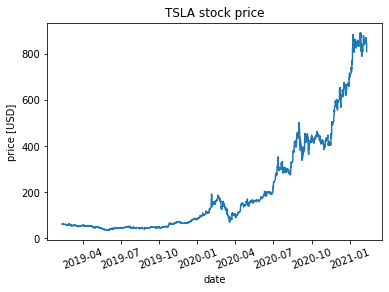

In [3]:
plt.plot(tsla['Open'])
plt.xlabel("date")
plt.xticks(rotation=20)
plt.ylabel("price [USD]")
plt.title("TSLA stock price")


img_tsla = "../report/img/img_tsla.pdf"
plt.savefig(img_tsla,bbox_inches="tight")

plt.show()

without big surprise the data is not stationary. So let's difference once to see what happens:

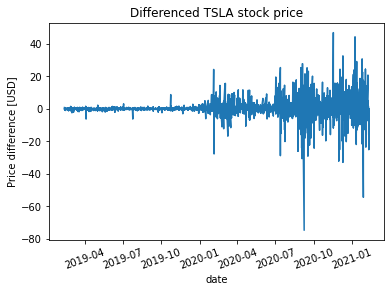

In [4]:
Dtsla = tsla['Open'].diff()
plt.plot(Dtsla)
plt.xlabel("date")
plt.xticks(rotation=20)
plt.ylabel("Price difference [USD]")
plt.title("Differenced TSLA stock price")
plt.show()

The data seems to be untrended, but it is clearly not homoskedastic, as it seems to get more volatile as time goes on. This would suggest taking the logarithm of the data. However in my course on Time Series, it's suggested to consider the log of the returns, so I will directly look at the series defined by:

100*\[log(O_t+1)-log(O_t)\]

where O_t is the open price at timestep t

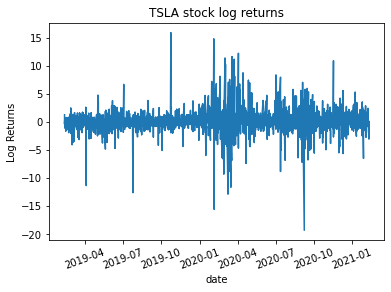

In [4]:
tsla_ret = 100*(np.log(tsla['Open'])).diff() #returns percentage

plt.plot(tsla_ret)
plt.xlabel("date")
plt.xticks(rotation=20)
plt.ylabel("Log Returns")
plt.title("TSLA stock log returns")

img_returns = "../report/img/img_returns.pdf"
plt.savefig(img_returns,bbox_inches="tight")

plt.show()

Now we are talking ! This seems like it could be stationary. Let's take a look at some diagnostic plots to see if it is indeed stationary (considering it's financial data, there's a good chance it's not gausian white noise, but it could be stationary at least)

## Diagnostic plots of returns

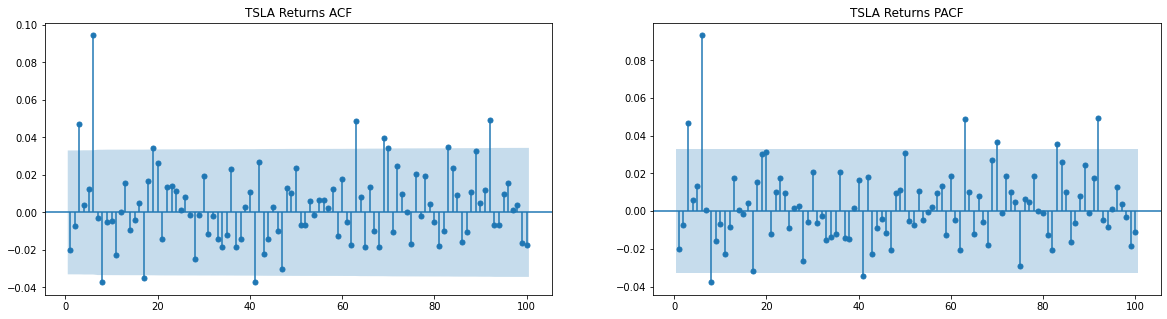

In [5]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(tsla_ret.dropna(),lags=100,zero=False,title="TSLA Returns ACF",ax=axs[0]) #acf of returns
plot_pacf(tsla_ret.dropna(),lags=100, zero=False, title="TSLA Returns PACF",ax=axs[1])

img_acf_tsla = "../report/img/img_acf_tsla.pdf"
plt.savefig(img_acf_tsla,bbox_inches="tight")

plt.show()

There would seem to be some dependence at lag 6 (lag 0 is not shown, so that it doesn't overshadow any low dependance). This is a bit surprising and odd in my opinion. I was expecting there to maaaaaybe be some dependence at lag 7, as there are 7 observations each day, but not at lag 6...  
But other than that, there's nothing that clearly indicates a possible AR, MA or combination of them. Nevertheless, for completeness, I'll try to fit some ARIMA models taking this lag 6 autocorrelation into account later on.

First though, let's check a QQ-plot for normality:

/home/sam/.pyenv/versions/PDM/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


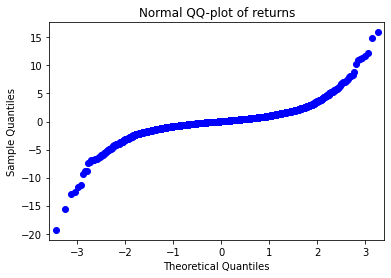

In [6]:
qqplot(tsla_ret)
plt.title("Normal QQ-plot of returns")

img_nqq_returns = "../report/img/img_nqq_returns.pdf"
plt.savefig(img_nqq_returns,bbox_inches="tight")

plt.show()

Clearly the returns are not normally distributed: They have heavier tails. I'm going to use a Student QQ-plot and manual tune the parameter to see it I get anything

/home/sam/.pyenv/versions/PDM/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


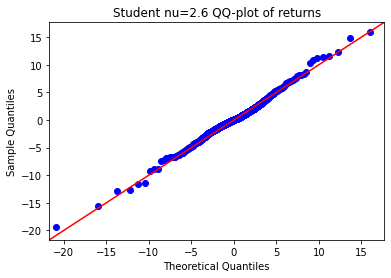

In [7]:
qqplot(tsla_ret, stats.t, distargs=(2.6,), line="45")
plt.title("Student nu=2.6 QQ-plot of returns")

img_tqq_returns = "../report/img/img_tqq_returns.pdf"
plt.savefig(img_tqq_returns,bbox_inches="tight")

plt.show()

So after some tuning, it looks as if the returns follow a student distribution with parameter about 2.6  
So maybe the returns are White Noise with dustribution t_2.6 then. Let's check the ACF and PACF of the squared returns (as suggested in my Times Series class), to see if by any change there is some pattern in the volatility.

### ACF and PACF of squared returns

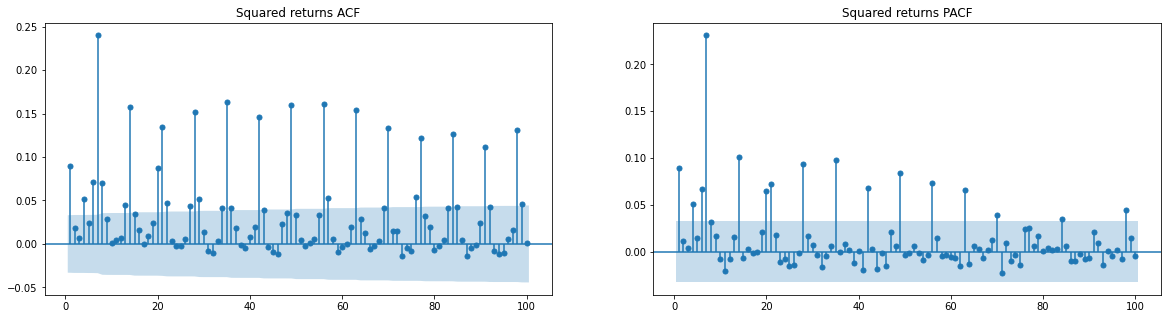

In [8]:
tsla_sret = tsla_ret**2
#plt.plot(tsla_sret)

fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(tsla_sret.dropna(),zero=False, lags=100,title="Squared returns ACF",ax=axs[0])
plot_pacf(tsla_sret.dropna(),zero=False, lags=100,title="Squared returns PACF", ax=axs[1])

img_sreturns = "../report/img/img_sreturns.pdf"
plt.savefig(img_sreturns,bbox_inches="tight")

plt.show()

I was very much not expecting this. Not only is there clearly structure in the auto correlation, but there seems to be some periodicity at lags 7k, k=1,...  
So that means there's a daily dependence in volatility. Like everyday certains times of day or more volatile than other times of the day.  
Let me try to differentiate the data with a lag of 7, to see if we can remove this effect. There's probably some underlying periodicity that was weak enough not to show up in the first ACF/PACF

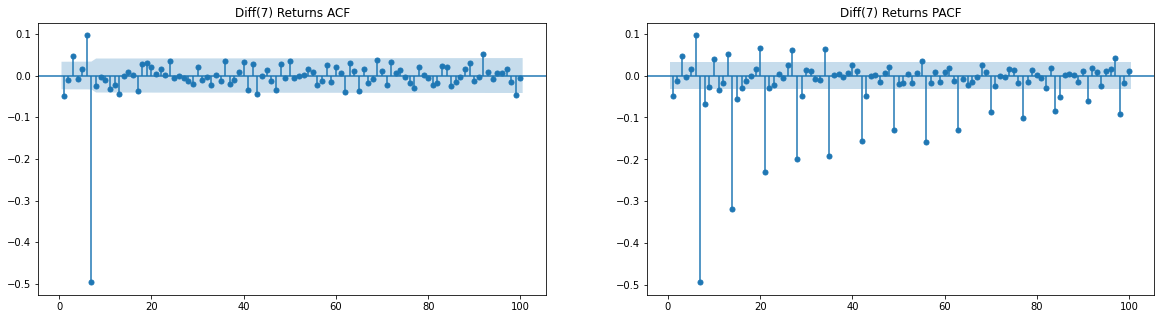

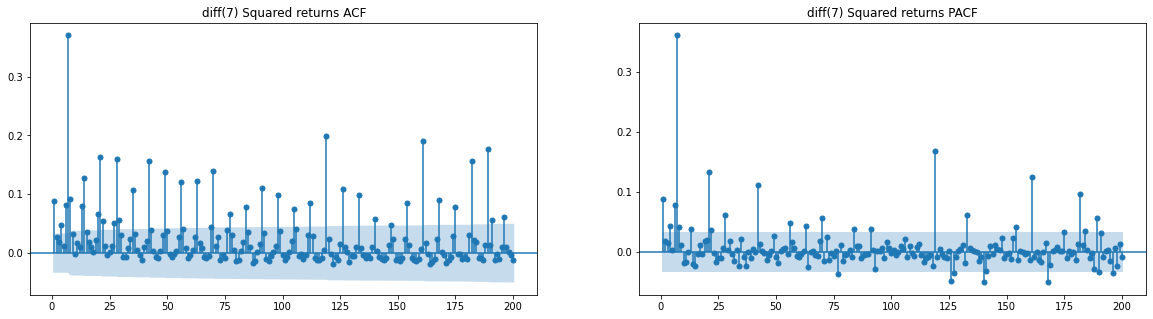

In [9]:
tsla_ret7 = tsla_ret.diff(7)
fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(tsla_ret7.dropna(), lags=100, zero=False,title="Diff(7) Returns ACF",ax=axs[0]) #acf of returns
plot_pacf(tsla_ret7.dropna(), lags=100, zero=False, title="Diff(7) Returns PACF", ax=axs[1])
plt.show()

tsla_sret7 = tsla_ret7**2
#plt.plot(tsla_sret7)
fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(tsla_sret7.dropna(),zero=False, lags=200, title="diff(7) Squared returns ACF",ax=axs[0]) #acf of returns
plot_pacf(tsla_sret7.dropna(),zero=False, lags=200, title="diff(7) Squared returns PACF", ax=axs[1])
plt.show()

Wow. That just made things worse. We clearly introduced some lag-7 autocoroleation in the original series now. The PACF now shows a bunch of periodicity too. What's more, looking at the squared returns the periodicity is still there... 

So let's drop that. Let's look at the periodogram of the returns and squared returns, to see if we see any hint of preiodicity:

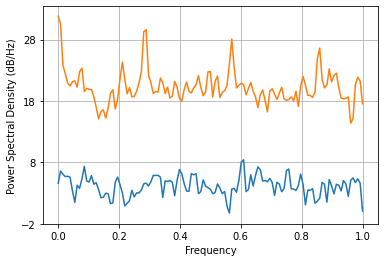

In [10]:
#fig, axs = plt.subplots(1,2,figsize=(20,5))
plt.psd(tsla_ret.dropna())
plt.psd(tsla_ret.dropna()**2)
plt.show()

Looking at the periodogramm of the returns (blue), there doesn't seems to be any frequency that stands out more than the others.  
However when looking at the periodogramm of the squared returns, we see some spikes around maybe 0.28, 0.57, 0.85

I don't really know what to make of this...  

Let's try using at STL decomposition to see if it can helps us figure the periodicity out.

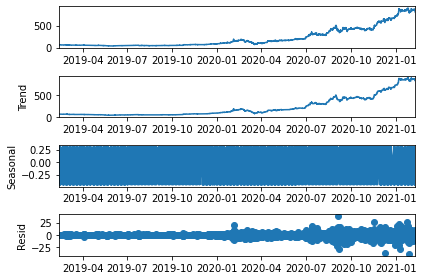

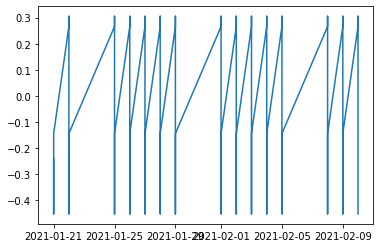

In [11]:
res = seasonal_decompose(tsla.dropna(),period=7,model="additive")
res.plot()
plt.show()
plt.plot(res.seasonal[-100:])

Well that doesn't seem helpfull for one thing, the seasonality looks strange, and the residuals look like they get increasingly more volatile.

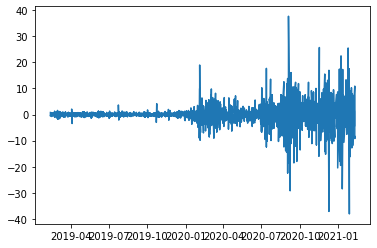

In [12]:
plt.plot(res.resid)

Yes they diffenitly get more volatile. Let's look at some diagnostic plots of the STL decomposition anyways, just to check

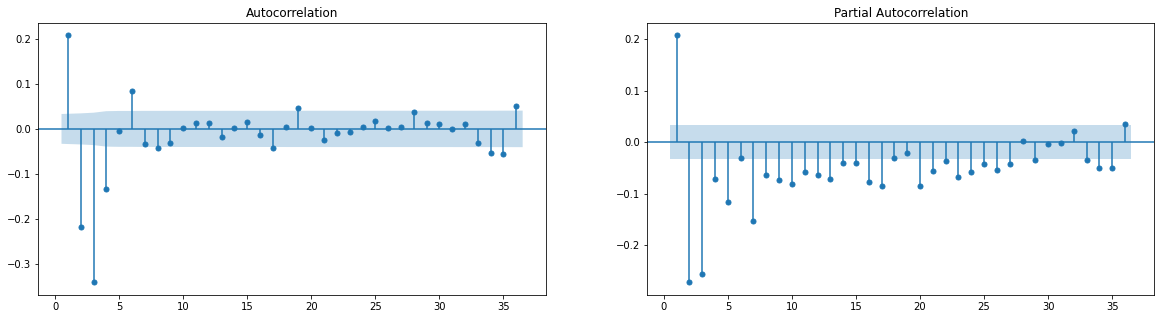

/home/sam/.pyenv/versions/PDM/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


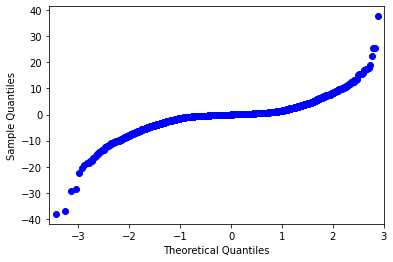

In [13]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(res.resid.dropna(),zero=False,ax=axs[0])
plot_pacf(res.resid.dropna(),zero=False,ax=axs[1])
plt.show()
qqplot(res.resid)
plt.show()

It's no better than just considering the log returns

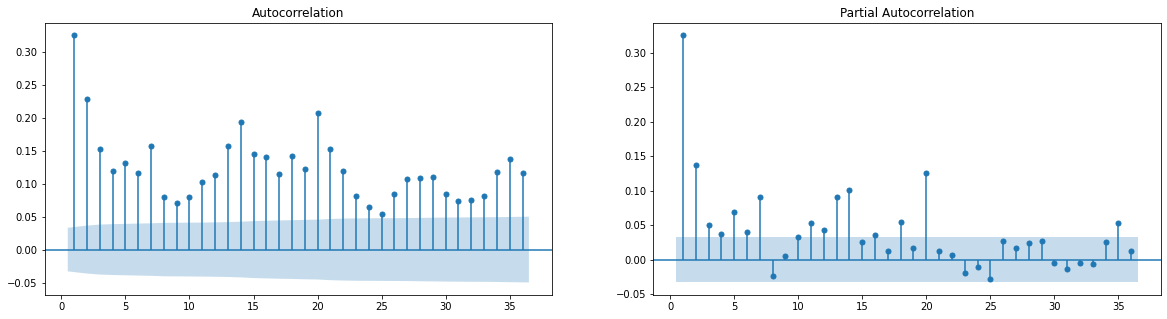

In [14]:
sresid = (res.resid)**2
fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf(sresid.dropna(),zero=False,ax=axs[0])
plot_pacf(sresid.dropna(),zero=False,ax=axs[1])
plt.show()

The volatilty structure is even wore than considering the returns.

I did find and explanation as to why there could be structure in the squared returns that is not present in the original data: apparently there is a phenomena called "volatility clustering" where volatility breeds volatility, so a great volatilty period will likely follow a period with great volatility (it however doesn't explain why it's periodic here...).  

This is actualy one of the main reasons to use a GARCH model, to model this volatility dependence. So without thinking too much, let's try a GARCH model, with small parameters and student t residual distribution

Iteration:      1,   Func. Count:      6,   Neg. LLF: 39171.70441150865
Iteration:      2,   Func. Count:     13,   Neg. LLF: 8935.651154492994
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7890.543456387797
Iteration:      4,   Func. Count:     26,   Neg. LLF: 6017.09032907381
Iteration:      5,   Func. Count:     32,   Neg. LLF: 7247.746475626938
Iteration:      6,   Func. Count:     38,   Neg. LLF: 7008.832604258883
Iteration:      7,   Func. Count:     44,   Neg. LLF: 7062.951338444651
Iteration:      8,   Func. Count:     50,   Neg. LLF: 5637.264621108156
Iteration:      9,   Func. Count:     56,   Neg. LLF: 5485.25871437375
Iteration:     10,   Func. Count:     61,   Neg. LLF: 5563.536066480694
Iteration:     11,   Func. Count:     67,   Neg. LLF: 6075.348547319667
Iteration:     12,   Func. Count:     75,   Neg. LLF: 5484.416107046443
Iteration:     13,   Func. Count:     81,   Neg. LLF: 5478.7142749697705
Iteration:     14,   Func. Count:     86,   Neg. LLF: 5478.377592

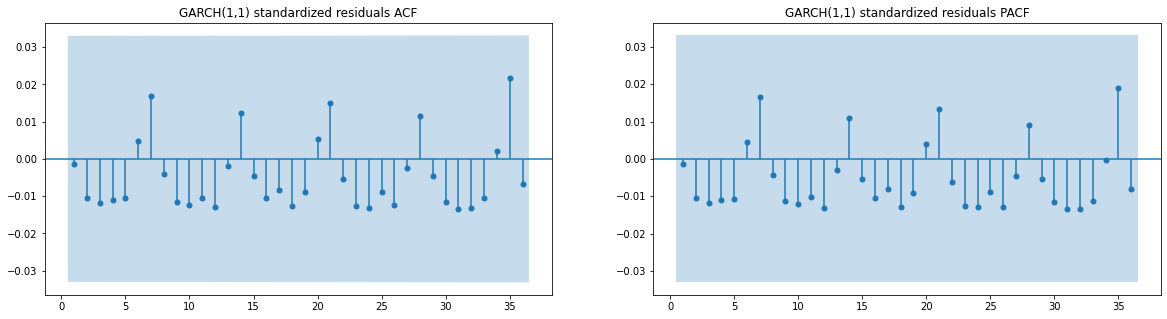

/home/sam/.pyenv/versions/PDM/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


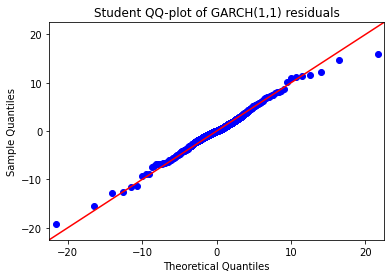

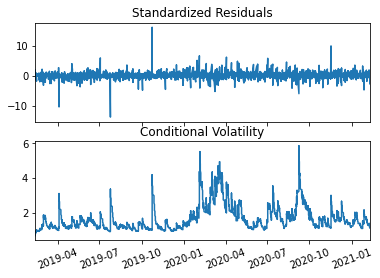

In [15]:
model = arch_model(tsla_ret.dropna(), mean='Zero', vol='GARCH', p=1, q=1, dist='t')
model_fit = model.fit() #update_freq=7

print(model_fit.summary())

fig, axs = plt.subplots(1,2,figsize=(20,5))
plot_acf((model_fit.std_resid.dropna())**2,zero=False,title="GARCH(1,1) standardized residuals ACF",ax=axs[0])
plot_pacf((model_fit.std_resid.dropna())**2,zero=False,title="GARCH(1,1) standardized residuals PACF",ax=axs[1])
path_img_acf_garch = "../report/img/img_acf_garch.pdf"
plt.savefig(path_img_acf_garch, bbox_inches="tight")
plt.show()

qqplot(model_fit.resid, dist=stats.t, distargs=(model_fit.params[-1],), line="45")
plt.title("Student QQ-plot of GARCH(1,1) residuals")
path_img_sqq_garch = "../report/img/img_sqq_garch.pdf"
plt.savefig(path_img_sqq_garch, bbox_inches="tight")
plt.show()

model_fit.plot()
plt.xticks(rotation=20)
path_img_resid_garch = "../report/img/img_resid_garch.pdf"
plt.savefig(path_img_resid_garch, bbox_inches="tight")
plt.show()

Wooow that worked surprisingly well ! All the coeficients are very significant. There's still that periodicity of 7 in the ACF and PACF, but it's all within the confidence interval, so even though I can't really explain why it's there, it doesn't look like it affects the GARCH in any way. The GARCH model found a parameter of 2.56 for the student parameters, which is close to what I found by manual tuning (2.6). The standardized residuals looks very much like White Noise now.

So the log returns seem to follow a GARCH(1,1) model with residuals t(2.56) distribution.

Next let's see if we can forecast some new observations

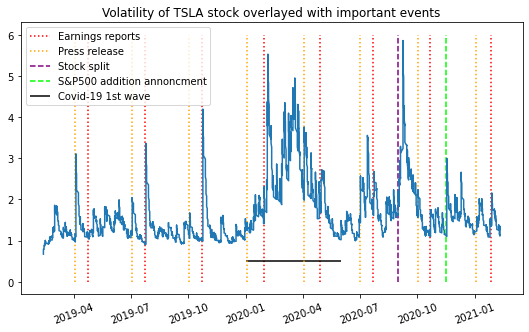

In [46]:
Q418 = pd.Timestamp("2019-1-30")
Q119 = pd.Timestamp("2019-4-24")
Q219 = pd.Timestamp("2019-7-24")
Q319 = pd.Timestamp("2019-10-23")
Q419 = pd.Timestamp("2020-1-29")
Q120 = pd.Timestamp("2020-4-29")
Q220 = pd.Timestamp("2020-7-22")
Q320 = pd.Timestamp("2020-10-21")
Q420 = pd.Timestamp("2021-1-27") #2021-1-27

stock_split = pd.Timestamp("2020-8-31")
snp500 = pd.Timestamp("2020-11-16")

PR418 = pd.Timestamp("2019-1-2")
PR119 = pd.Timestamp("2019-4-3")
PR219 = pd.Timestamp("2019-7-2")
PR319 = pd.Timestamp("2019-10-2")
PR419 = pd.Timestamp("2020-1-3")
PR120 = pd.Timestamp("2020-4-2")
PR220 = pd.Timestamp("2020-7-2")
PR320 = pd.Timestamp("2020-10-2")
PR420 = pd.Timestamp("2021-1-2")

#print(dir(model_fit))
plt.figure(figsize=(9,5))
plt.plot(model_fit.conditional_volatility)
plt.xticks(rotation=20)

line1 = plt.vlines(Q119,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q219,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q319,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q419,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q120,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q220,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q320,ymin=0,ymax=6,color='r', linestyles="dotted")
plt.vlines(Q420,ymin=0,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q119,ymin=2,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q219,ymin=4,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q319,ymin=4.5,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q419,ymin=3,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q120,ymin=3,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q220,ymin=3,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q320,ymin=2,ymax=6,color='r', linestyles="dotted")
#plt.vlines(Q420,ymin=2,ymax=6,color='r', linestyles="dotted")



line3 = plt.vlines(stock_split,ymin=0,ymax=6,color='purple',linestyles="dashed")
#plt.vlines(stock_split,ymin=4,ymax=6,color='purple',linestyles="dashdot")
line4 = plt.vlines(snp500,ymin=0,ymax=6,color='lime',linestyles="dashed")
#plt.vlines(snp500,ymin=3.5,ymax=6,color='black',linestyles="dashdot")
line5 = plt.hlines(0.5,xmin=pd.Timestamp("2020-1-1"),xmax=pd.Timestamp("2020-6-1"),color='black')

line2 = plt.vlines(PR119,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR219,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR319,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR419,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR120,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR220,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR320,ymin=0,ymax=6,color='orange', linestyles="dotted")
plt.vlines(PR420,ymin=0,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR119,ymin=3.5,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR219,ymin=2,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR319,ymin=2,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR419,ymin=2,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR120,ymin=4.5,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR220,ymin=3.5,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR320,ymin=3,ymax=6,color='orange', linestyles="dotted")
#plt.vlines(PR420,ymin=2,ymax=6,color='orange', linestyles="dotted")

plt.legend(handles=[line1,line2,line3,line4,line5],labels=["Earnings reports","Press release","Stock split","S&P500 addition annoncment","Covid-19 1st wave"],loc='upper left')
plt.title("Volatility of TSLA stock overlayed with important events")
path_img_resid_garch = "../report/img/img_volatility_explanation.pdf"
plt.savefig(path_img_resid_garch, bbox_inches="tight")
plt.show()

In [56]:
futur = model_fit.forecast(horizon=35,reindex=False) #,start=-1

In [57]:
print(futur.variance[-20:])

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2021-02-10  1.560468  1.602787  1.645105  1.687424  1.729743  1.772061   

               h.07      h.08      h.09      h.10  ...      h.26      h.27  \
Date                                               ...                       
2021-02-10  1.81438  1.856698  1.899017  1.941336  ...  2.618433  2.660751   

               h.28      h.29      h.30      h.31      h.32      h.33  \
Date                                                                    
2021-02-10  2.70307  2.745389  2.787707  2.830026  2.872344  2.914663   

                h.34    h.35  
Date                          
2021-02-10  2.956982  2.9993  

[1 rows x 35 columns]


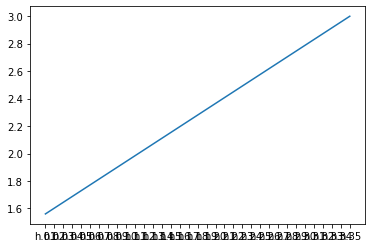

In [58]:
plt.plot(futur.variance.iloc[-1])